In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
#import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

## Camera Calibration

In [2]:
def camera_calibration():
    
    global camera_mtx,dist_coeff
    # Preparing the points for the object 
    objectPoints = np.zeros((6 * 9, 3), np.float32)
    objectPoints[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Storing all the points for the object and the image from all the images
    object_points = []
    image_points = []

    # Getting the directory of all of the calibrated images
    img = glob.glob('./camera_calibrations/*.jpg')
    images = None

    for indx, fname in enumerate(img):
        images = cv2.imread(fname)
        gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
        # it should be colored image or a 8-bit grayscale  
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            object_points.append(objectPoints)
            image_points.append(corners)

    # getting the size of the Image 
    imageSize = (images.shape[1], images.shape[0])

    # Calibrate camera
    ret, camera_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imageSize, None, None)

camera_calibration()

## Undistorting image using camera matrix and distortion coefficient

In [3]:
def undistort(images, camera_mtx, dist_coeff):
    """
    we will use cv2.undistort to undistort
    :param images: we will assume that the input image is RGB (imread by mpimg)
    :param camera_mtx: it the parameter for the calibration of the camera 
    :param dist_coeff:is a calibration parameter for the camera
    :return: Undistorted image
    """
   
    undistorted_img = cv2.undistort(images, camera_mtx, dist_coeff, None, camera_mtx)

    return undistorted_img

## Testing a Road Image

Text(0.5, 1.0, 'Undistorted Image')

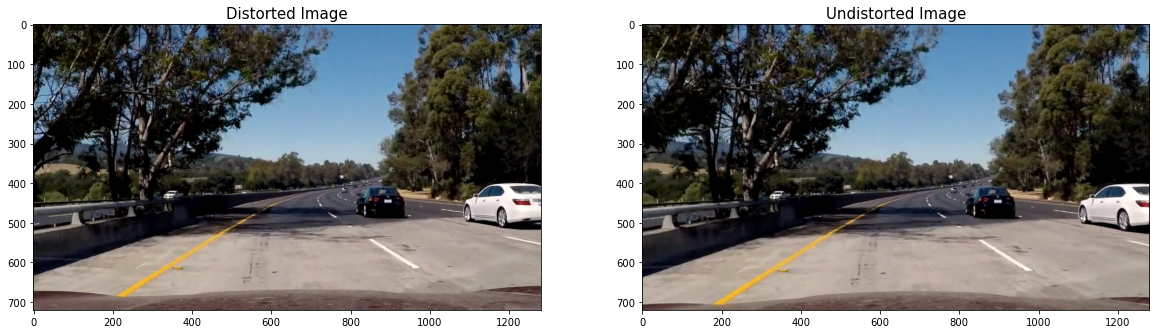

In [4]:
img = cv2.imread('test_images/test5.jpg')

# transform to BGR to fit cv2.imread
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort(img, camera_mtx, dist_coeff)


f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize = 15)

ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize = 15)

## Perspective Transform and Inverse Perspective Transform

In [5]:
src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
def perspective_transform(img):
    """
    Perspective Transformation
    :param img:
    :return: warped image
    """
    

    
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def inv_perspective_transform(img):
    """
    Inverse Perspective Transformation
    :param img:
    :return: warped image
    """

    dst = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    src = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the inverse-perspective transform matrix 
    #(which is just perspective transform with src and dst interchanged)
    Minv = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, Minv, img_size)
    
    return warped

Text(0.5, 1.0, 'Warped Image')

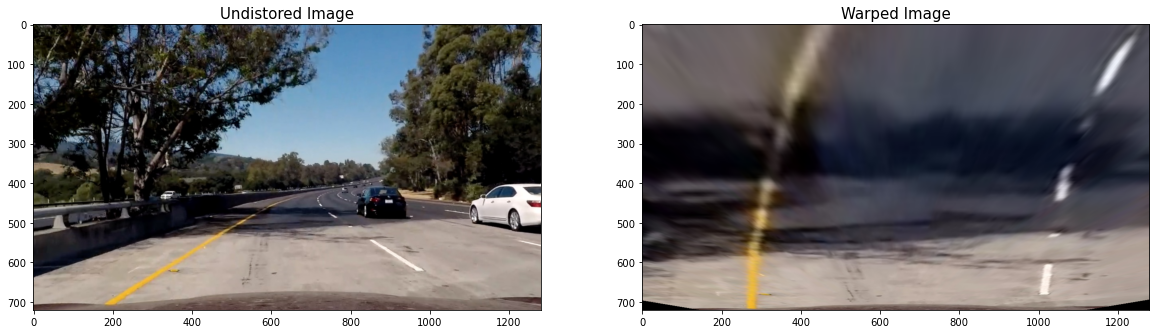

In [6]:
warped = perspective_transform(undistorted_img)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undistorted_img)
ax1.set_title('Undistored Image', fontsize = 15)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize = 15)

## Thresholding

In [7]:
#differences in RGB space do not correspond well to perceived differences in color. 
#That is, two colors can be close in RGB space but appear very different to humans and vice versa.

#LUV decouple the "color" (chromaticity, the UV part) and "lightness" (luminance, the L part) of color.
#Thus in object detection, it is common to match objects just based on the UV part,
#which gives invariance to changes in lighting condition.

#LAB is designed to approximate human vision. The L* component closely matches human perception of lightness
#is useful for predicting small differences in color.

#So we will use B channel from LAB space identified yellow lanes while L channel from LUV space could detect white lanes

def thresholding(img, l_thresh=(195, 255), b_thresh=(140, 200)):
    l_LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:, :, 0]
    l_bin = np.zeros_like(l_LUV)
    l_bin[(l_LUV >= l_thresh[0]) & (l_LUV <= l_thresh[1])] = 1

    b_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:, :, 2]
    b_bin = np.zeros_like(b_LAB)
    b_bin[(b_LAB >= b_thresh[0]) & (b_LAB <= b_thresh[1])] = 1

    thresholded_img = np.zeros_like(l_LUV)
    thresholded_img[(l_bin == 1) | (b_bin == 1)] = 1

    return thresholded_img

Text(0.5, 1.0, 'Threshold Image')

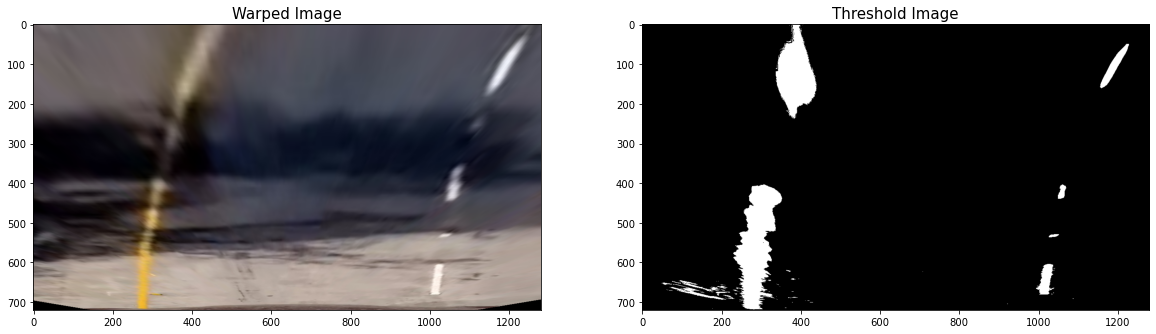

In [8]:
filtered=thresholding(warped)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize = 15)

ax2.imshow(filtered, cmap='gray')
ax2.set_title('Threshold Image', fontsize = 15)

## Histogram For Thresholded Wraped image

In [9]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

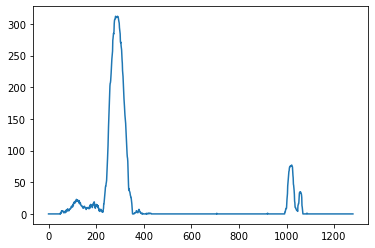

In [10]:
plt.plot(get_hist(filtered))

## The Lane detection class

In [11]:
class Lane_detection:
    def __init__(self):
        # the value of (x) and the value of (y) in the previous frame
        self.x = None
        self.y = None
        self.detected = False  #to discover if the lane detected in the previous loop 
        # The intercepts of x for the average smoothing
        self.topX = deque(maxlen=frameNum)
        self.bottomX = deque(maxlen=frameNum)
        # Recording the last intercepts for x
        self.current_topX = None
        self.current_bottomX = None
        # The Polynomial coefficients: x = A(y^2) + By + C
        self.A = deque(maxlen=frameNum)
        self.B = deque(maxlen=frameNum)
        self.C = deque(maxlen=frameNum)
        self.fit = None
        self.fitx = None
        self.fity = None
    def getIntercepts(self):
        top = self.fit[2]
        bottom = self.fit[0] * 720 ** 2 + self.fit[1] * 720 + self.fit[2]
        return bottom,top
    def quickSearch(self, img, non_zero_x, non_zero_y):
        """
        Assume that in the previous frame,
        the lane is detected according to the previous x/y coordinates,quick search current lane.
        """
        x_inds = []
        y_inds = []
        outImage = np.dstack((img, img, img)) * 255
        if self.detected:
            winTop = 630
            winBottom = 720
            while winTop >= 0:
                y_val = np.mean([winTop, winBottom])
                x_val = (np.median(self.A)) * y_val ** 2 + (np.median(self.B)) * y_val + (np.median(self.C))
                x_idx = np.where((((x_val - 50) < non_zero_x)
                                  & (non_zero_x < (x_val + 50))
                                  & ((non_zero_y > winTop) & (non_zero_y < winBottom))))
                xWindow, yWindow = non_zero_x[x_idx], non_zero_y[x_idx]
                cv2.rectangle(outImage, (int(x_val - 50), winTop), (int(x_val + 50), winBottom),
                              (0, 255, 0), 2)
                if np.sum(xWindow) != 0:
                    np.append(y_inds, yWindow)
                    np.append(x_inds, xWindow)
                winBottom -= 90   
                winTop -= 90
        if np.sum(x_inds) == 0:
            # If there is no lane detected blind search will be used
            self.detected = False  
        return  outImage, x_inds, y_inds   

    def blindSearch(self,img, non_zero_x, non_zero_y):
        """
        this search method by Sliding the window, starting from blank.
        """
        outImage = np.dstack((img, img, img)) * 255
        x_inds = []
        y_inds = []
        if self.detected is False:
            winTop = 630
            winBottom = 720
            histogramComplete = np.sum(img[200:, :], axis=0)
            while winTop >= 0:
                histogram = np.sum(img[winTop:winBottom, :], axis=0)
                if self == right:
                    base = (np.argmax(histogram[640:-60]) + 640) \
                    if np.argmax(histogram[640:-60]) > 0\
                    else (np.argmax(histogramComplete[640:]) + 640)
                else:
                    base = np.argmax(histogram[:640]) \
                        if np.argmax(histogram[:640]) > 0 \
                        else np.argmax(histogramComplete[:640])
                x_idx = np.where((  (non_zero_x < (base + 50))&((base - 50) < non_zero_x)
                                  & ((non_zero_y > winTop) & (non_zero_y < winBottom))))
                xWindow, yWindow = non_zero_x[x_idx], non_zero_y[x_idx]
                cv2.rectangle(outImage, (int(base - 50), winTop), (int(base + 50), winBottom),
                              (0, 255, 0), 2)
                if np.sum(xWindow) != 0:
                    y_inds.extend(yWindow)
                    x_inds.extend(xWindow)
                winBottom -= 90   
                winTop -= 90
        if np.sum(x_inds) > 0:
            self.detected = False
        else:
            x_inds = self.x
            y_inds = self.y
            
        return  outImage,x_inds, y_inds 
    
    def sortYdx(self):
        """
        Sorting (x, y) according to the index of y
        """
        sortedYdx = np.argsort(self.y)
        sortedY = self.y[sortedYdx]
        sortedX = self.x[sortedYdx]
        return sortedX, sortedY

    def getFit(self):
        """
        according to the coordinates of the searched x and y, polyfit by second order
        Take median value in previous frames to smooth.
        """
        self.fit = np.polyfit(self.y, self.x, 2)
        self.current_bottomX, self.current_topX = self.getIntercepts()
        self.bottomX.append(self.current_bottomX)
        self.topX.append(self.current_topX)
        self.current_bottomX = np.median(self.bottomX)
        self.current_topX = np.median(self.topX)
        self.x = np.append(self.x, self.current_bottomX)
        self.x = np.append(self.x, self.current_topX)
        self.y = np.append(self.y, 720)
        self.y = np.append(self.y, 0)
        self.x, self.y = self.sortYdx()
        self.fit = np.polyfit(self.y, self.x, 2)
        self.A.append(self.fit[0])
        self.B.append(self.fit[1])
        self.C.append(self.fit[2])
        self.fitY = self.y
        self.fit = [np.median(self.A), np.median(self.B), np.median(self.C)]
        self.fitX = self.fit[0] * self.fitY ** 2 + self.fit[1] * self.fitY + self.fit[2]

        return self.fit, self.fitX, self.fitY

## Draw Lane

In [12]:
def drawLane(undistortedImage, leftFitX,rightFitX,leftY, rightY):
    """
    an undistorted original image and warped image was given,this function draw the final lane on the undistorted image
    """
    Min_v = cv2.getPerspectiveTransform(dst, src)
    # Creating image for drawing on it the line 
    warpZero = np.zeros(img_shape[0:2]).astype(np.uint8)
    colorWarp = np.dstack((warpZero, warpZero, warpZero))
    # Recasting (x, y)into a usable format suitable for cv2.fillPoly()
    pointsRight = np.array([np.transpose(np.vstack([rightFitX, rightY]))])
    pointsLeft = np.array([np.flipud(np.transpose(np.vstack([leftFitX, leftY])))])
    points = np.hstack((pointsLeft, pointsRight))
    cv2.polylines(colorWarp, np.int_([points]),isClosed=False, color=(200, 0, 0), thickness=30)
    # Drawing lane on the warped blank image
    cv2.fillPoly(colorWarp, np.int_([points]), (0,255, 0))
    # Warping the blank back onto the original image using the inverse perspective matrix (Min_v)
    new_warp = inv_perspective_transform(colorWarp)
    # Combining result with original image
    r = cv2.addWeighted(undistortedImage, 1, new_warp, 0.3,  0)
    
    return r

## The Position of the vehicle from the lane center

In [13]:
def VehiclePos(rightFit,leftFit):
    """
    for Calculating the car position on the right and left from the base of the lane  
    :param rightFit, leftFit:
    :return: the distance of the car in meter and it's offset from the middle of the right lane and left lane
    """   
    xleft_eval = leftFit[0] * np.max(ploty) ** 2 + leftFit[1] * np.max(ploty) + leftFit[2]
    xright_eval = rightFit[0] * np.max(ploty) ** 2 + rightFit[1] * np.max(ploty) + rightFit[2]
    # the meters per pixel for y dimension
    ym_per_pix = 18 / 720  
    # the meters per pixel for x dimension
    xm_per_pix = 3.7 / abs(xleft_eval - xright_eval)  
    
    
    lane_center_position = np.mean((xleft_eval, xright_eval))
    # +: the car is in the right
    # -: the car is in the left 
    car_center_offset = (img_shape[1]/2 - lane_center_position) * xm_per_pix  
    
    return car_center_offset

## The road radius of curvature

In [14]:
def RadiusCurvature( rightFit,leftFit):
    """
    for calculating the road radius of curvature 
    :param rightFit,leftFit:
    :return: the distance in meter of the right and left curverad
    """
    xleft_eval = leftFit[0] * np.max(ploty) ** 2 + leftFit[1] * np.max(ploty) + leftFit[2]
    xright_eval = rightFit[0] * np.max(ploty) ** 2 + rightFit[1] * np.max(ploty) + rightFit[2]
    # the meter per pixel for the y dimension   
    ym_per_pix = 18 / 720  
     # the meter per pixel for the x dimension
    xm_per_pix = 3.7 / abs(xleft_eval - xright_eval)  

    

    y_eval = np.max(ploty)
    left_fitx = leftFit[0] * ploty ** 2 + leftFit[1] * ploty + leftFit[2]
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * left_fit_cr[0])

    right_fitx = rightFit[0] * ploty ** 2 + rightFit[1] * ploty + rightFit[2]
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * right_fit_cr[0])
    
    

    return  right_curverad,left_curverad

In [15]:
def vconcatResizeMin(im_list, interpolation=cv2.INTER_CUBIC):
    wMin = min(im.shape[1] for im in im_list)
    imListResize = [cv2.resize(im, (wMin, int(im.shape[0] * wMin / im.shape[1])), interpolation=interpolation)
                      for im in im_list]
    return cv2.vconcat(imListResize)
def hconcatResizeMin(imList, interpolation=cv2.INTER_CUBIC):
    hMin = min(im.shape[0] for im in imList)
    imListResize = [cv2.resize(im, (int(im.shape[1] * hMin / im.shape[0]), hMin), interpolation=interpolation)
                      for im in imList]
    return cv2.hconcat(imListResize)
def concatTileResize(imList2d, interpolation=cv2.INTER_CUBIC):
    imListV = [hconcatResizeMin(imListH, interpolation=cv2.INTER_CUBIC) for imListH in imList2d]
    return vconcatResizeMin(imListV, interpolation=cv2.INTER_CUBIC)

## Pipeline

In [16]:
def pipeline(img):

    global debug

    undist_img = undistort(img, camera_mtx, dist_coeff,)

    warped = perspective_transform(img)

    warped_binary = thresholding(warped, l_thresh=(215, 255),b_thresh=(145, 200))

    nonzerox, nonzeroy = np.nonzero(np.transpose(warped_binary))

    if left.detected is True:
        out_img_left,leftx, lefty = left.quickSearch(warped_binary,nonzerox, nonzeroy)
    if right.detected is True:
        out_img_right,rightx, righty = right.quickSearch(warped_binary,nonzerox, nonzeroy)
    if left.detected is False:
        out_img_left,leftx, lefty = left.blindSearch(warped_binary,nonzerox, nonzeroy)
    if right.detected is False:
        out_img_right,rightx, righty = right.blindSearch(warped_binary,nonzerox, nonzeroy)


    out_combine = cv2.addWeighted(out_img_left, 1, out_img_right, 0.5, 0)

    left.y = np.array(lefty).astype(np.float32)
    left.x = np.array(leftx).astype(np.float32)
    right.y = np.array(righty).astype(np.float32)
    right.x = np.array(rightx).astype(np.float32)

    left_fit, left_fitx, left_fity = left.getFit()
    right_fit, right_fitx, right_fity = right.getFit()

    offset = VehiclePos(right_fit, left_fit)
    
    measures = RadiusCurvature(right_fit, left_fit)

    mean_curv = np.mean([measures[0], measures[1]])
    
    result = drawLane(undist_img, left_fitx, right_fitx, left_fity, right_fity)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
   
    cur1 = 'Lane Curvature: %d m'
    cur2 = 'Lane Curvature: Inf m'
    offset_text = 'Vehicle offset: %.2f m'
    
    if mean_curv < 3000:
        cv2.putText(result, cur1 % (int(mean_curv)),(500, 620), font, fontSize, fontColor, 2)
    else:
        cv2.putText(result, cur2 ,(500, 620), font, fontSize, fontColor, 2)
    cv2.putText(result, offset_text % (-offset),(500, 650), font, fontSize, fontColor, 2)

    if debug:
        warped_binary_t=np.dstack((warped_binary,warped_binary,warped_binary))*255
        result = concatTileResize([[undist_img, warped_binary_t,out_combine], [result]])

    return result

In [17]:
def draw(img):

    out = pipeline(img)

    plt.figure(figsize=(10, 6))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Orginal Image')
    plt.subplot(222)
    plt.imshow(out)
    plt.title('Lane Detection')
    plt.show()
    return

## Lane Detecting of Test images

Image  0 :  test_images\straight_lines1.jpg


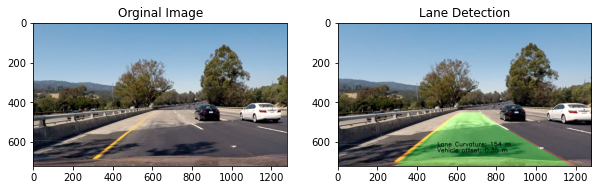

Image  1 :  test_images\straight_lines2.jpg


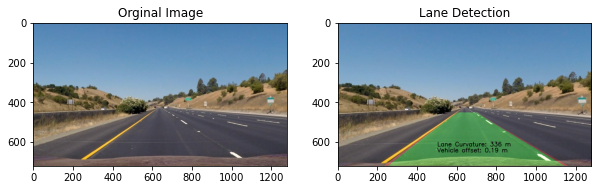

Image  2 :  test_images\test1.jpg


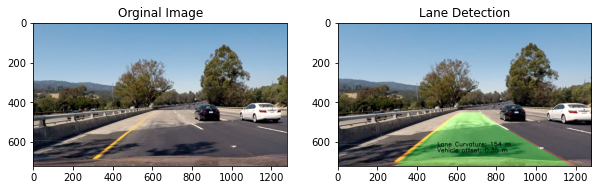

Image  3 :  test_images\test2.jpg


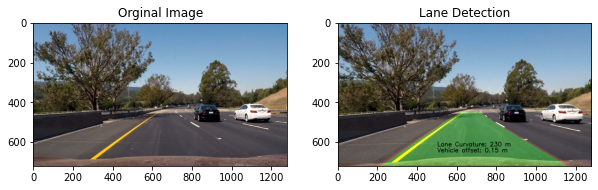

Image  4 :  test_images\test3.jpg


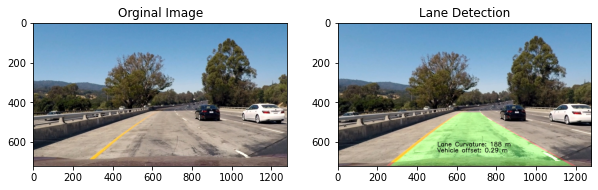

Image  5 :  test_images\test4.jpg


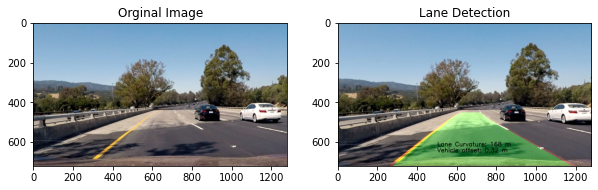

Image  6 :  test_images\test5.jpg


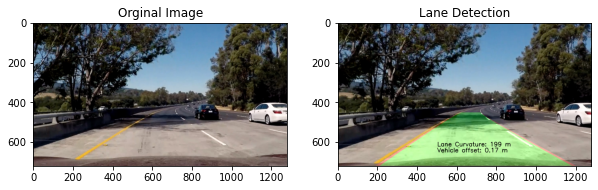

Image  7 :  test_images\test6.jpg


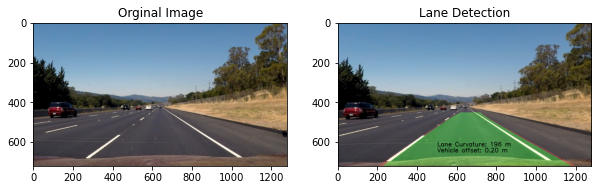

In [18]:
img_shape = (720, 1280)
img_size = [1280, 720]  # width, height


ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
debug = True

camera_calibration()
debug = False
frameNum = 15   # latest frames number of good detection
left = Lane_detection()
right = Lane_detection()


images = glob.glob('test_images/*.jpg')
for i in range(len(images)):
    print("Image ", i, ": " ,images[i] )

    choice = np.random.choice(len(images))

    img = cv2.imread(images[choice])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw(img)
debug = True

## Lane Detecting of Videos

In [19]:
#uncomment the video path you want

myclip = VideoFileClip('project_video.mp4')
#myclip = VideoFileClip('challenge_video.mp4')
#myclip = VideoFileClip('harder_challenge_video.mp4')

output_vid = 'project_video_output1.mp4'
#output_vid = 'challenge_video_output1.mp4'
#output_vid = 'harder_challenge_video_output1.mp4'

clip = myclip.fl_image(pipeline)
clip.write_videofile(output_vid, audio=False)
myclip.reader.close()
myclip.close()

Moviepy - Building video project_video_output1.mp4.
Moviepy - Writing video project_video_output1.mp4



Moviepy - Done !
Moviepy - video ready project_video_output1.mp4
